In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import gaussian_kde
import folium
from folium.plugins import HeatMap
from sklearn.cluster import DBSCAN
import os
from branca.colormap import linear


In [4]:
OUTDIR= "analyze_poi"

# Read data

In [5]:
df = pd.read_csv("poi_osm/fix/osm_poi_kode.csv")
df.columns = [c.strip().lower() for c in df.columns]

In [6]:
lat_col = "latitude"
lon_col = "longitude"
cat_col = "category"
region_col = "kabupaten_kota" if "kabupaten_kota" in df.columns else None

In [7]:
df[lat_col] = pd.to_numeric(df[lat_col], errors="coerce")
df[lon_col] = pd.to_numeric(df[lon_col], errors="coerce")

print("Jumlah baris:", len(df))
df.head()

Jumlah baris: 56166


,unnamed: 0.1,unnamed: 0,id,kabupaten_kota,kode_kabupaten,name,category,latitude,longitude,addr:city,source
0,0,0,node/411668893,Jakarta Barat,31.73,Hero,supermarket,-6.165670,106.759241,NaN,NaN
1,1,1,node/412686079,Jakarta Barat,31.73,Super Indo,supermarket,-6.165414,106.782067,NaN,NaN
2,2,2,node/1354554837,Jakarta Barat,31.73,NaN,atm,-6.189133,106.796257,NaN,NaN
3,3,3,node/1354554844,Jakarta Barat,31.73,CFC,restaurant,-6.189235,106.796378,NaN,NaN
4,4,4,node/1541706845,Jakarta Barat,31.73,Super Indo,supermarket,-6.216578,106.765227,NaN,NaN


# Preprocessing


In [27]:
df['category'].unique()

array(['supermarket', 'atm', 'restaurant', 'convenience', 'hairdresser',
       'cinema', 'bakery', 'mall', 'travel_agency', 'fast_food', 'bar',
       'farm', 'pet', 'greengrocer', 'beauty', 'funeral_directors',
       'books', 'mobile_phone', 'beverages', 'ticket', 'gift',
       'parking_entrance', 'clinic', 'university', 'place_of_worship',
       'laundry', 'shoes', 'massage', 'motorcycle', 'stationery',
       'car_repair', 'variety_store', 'optician', 'cafe',
       'department_store', 'houseware', 'tailor', 'chocolate', 'clothes',
       'car_parts', 'car', 'music_school', 'wine', 'sports', 'vacant',
       'food_court', 'computer', 'copyshop', 'pastry', 'bank', 'tyres',
       'photo', 'furniture', 'pawnbroker', 'electronics', 'hardware',
       'confectionery', 'florist', 'tea', 'kiosk', 'doityourself',
       'radiotechnics', 'rental', 'pastry;seafood', 'pharmacy',
       'telecommunication', 'nutrition_supplements', 'rice', 'fuel',
       'bicycle_parking', 'coffee', 'music

In [11]:
# A. Normalisasi kategori -> buckets
digital_buckets = {
    "cafe": ["cafe","coffee","coffee_shop","beverages","tea", "restaurant"],
    "coworking": ["coworking","co-working","co_working","coworking_space"],
    "university": ["university","college","kampus","school","language_school","training"],
    "electronics": ["electronics","mobile_phone","mobile_phone_accessories","computer","appliance","hifi","radiotechnics","camera","cell_phones", "cellular", "alpha computer".lower()],
    "telecom": ["telecommunication","telecom","tower","menara","charging_station"],
    "internet_service": ["internet","internet_cafe","wifi","digital_printing","bitcoin_community_house"],
    "mall": ["mall","shopping_centre","pusat_perbelanjaan","shopping"],
    "store": ["store","convenience","minimarket","supermarket","variety_store","department_store","retail","toserba"],
    "banking": ["bank","atm","bureau_de_change","money_transfer","payment_centre"],
}

def map_to_buckets(cat_val):
    if pd.isna(cat_val):
        return []
    text = str(cat_val).lower()
    parts = [p.strip() for p in text.split(';') if p.strip()!='']
    candidates = parts + [text]
    matches = set()
    for b, kwlist in digital_buckets.items():
        for kw in kwlist:
            for c in candidates:
                if kw in c:
                    matches.add(b)
    # heuristics for other forms
    if "cowork" in text:
        matches.add("coworking")
    if "wifi" in text or "internet" in text:
        matches.add("internet_service")
    if "university" in text or "college" in text:
        matches.add("university")
    if "electronics" in text or "mobile" in text or "cell" in text or "computer" in text:
        matches.add("electronics")
    return sorted(matches)

df["buckets"] = df[cat_col].apply(map_to_buckets) if cat_col else [[]]*len(df)
df["is_digital_poi"] = df["buckets"].apply(lambda x: len(x)>0)
df["buckets_str"] = df["buckets"].apply(lambda x: ";".join(x) if x else "")
# simple counts
from collections import Counter
bucket_counts = Counter()
for bl in df["buckets"]:
    bucket_counts.update(bl)
bucket_counts_df = pd.DataFrame(bucket_counts.items(), columns=["bucket","count"]).sort_values("count", ascending=False)
bucket_counts_df.to_csv(("analyze_poi/bucket_counts.csv"), index=False)
print("Digital POIs:", df['is_digital_poi'].sum())
display(bucket_counts_df)


Digital POIs: 19956


,bucket,count
0,store,14273
4,electronics,2407
2,cafe,1649
3,mall,910
1,banking,672
5,university,38
6,telecom,33
7,internet_service,11


In [12]:
df

,unnamed: 0.1,unnamed: 0,id,kabupaten_kota,kode_kabupaten,name,category,latitude,longitude,addr:city,source,buckets,is_digital_poi,buckets_str
0,0,0,node/411668893,Jakarta Barat,31.73,Hero,supermarket,-6.165670,106.759241,NaN,NaN,[store],True,store
1,1,1,node/412686079,Jakarta Barat,31.73,Super Indo,supermarket,-6.165414,106.782067,NaN,NaN,[store],True,store
2,2,2,node/1354554837,Jakarta Barat,31.73,NaN,atm,-6.189133,106.796257,NaN,NaN,[banking],True,banking
3,3,3,node/1354554844,Jakarta Barat,31.73,CFC,restaurant,-6.189235,106.796378,NaN,NaN,[cafe],True,cafe
4,4,4,node/1541706845,Jakarta Barat,31.73,Super Indo,supermarket,-6.216578,106.765227,NaN,NaN,[store],True,store
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56161,56161,56161,way/1159592008,Tulangbawang,18.05,NaN,chemist,NaN,NaN,NaN,NaN,[],False,
56162,56162,56162,way/1160380538,Tulangbawang,18.05,NaN,kiosk,NaN,NaN,NaN,NaN,[],False,
56163,56163,56163,way/1186182191,Tulangbawang,18.05,NaN,yes,NaN,NaN,NaN,NaN,[],False,
56164,56164,56164,way/1186354872,Tulangbawang,18.05,Alfamart,convenience,NaN,NaN,NaN,NaN,[store],True,store


In [13]:
import pandas as pd

# definisi bucket
digital_buckets = {
    "cafe": ["cafe","coffee","coffee_shop","beverages","tea", "restaurant"],
    "coworking": ["coworking","co-working","co_working","coworking_space"],
    "university": ["university","college","kampus","school","language_school","training"],
    "electronics": ["electronics","mobile_phone","mobile_phone_accessories","computer","appliance","hifi","radiotechnics","camera","cell_phones","cellular","alpha computer"],
    "telecom": ["telecommunication","telecom","tower","menara","charging_station"],
    "internet_service": ["internet","internet_cafe","wifi","digital_printing","bitcoin_community_house"],
    "mall": ["mall","shopping_centre","pusat_perbelanjaan","shopping"],
    "store": ["store","convenience","minimarket","supermarket","variety_store","department_store","retail","toserba"],
    "banking": ["bank","atm","bureau_de_change","money_transfer","payment_centre"],
}

# pastikan kolom category ada
df["category"] = df["category"].astype(str).str.lower()

# dictionary hasil pemisahan
bucket_dfs = {}

for bucket_name, keywords in digital_buckets.items():
    mask = df["category"].apply(lambda x: any(kw in x for kw in keywords))
    bucket_dfs[bucket_name] = df[mask].copy()

# contoh akses hasil
print("Jumlah kategori cafe:", len(bucket_dfs["cafe"]))
print("Jumlah kategori electronics:", len(bucket_dfs["electronics"]))

# kalau mau export tiap df ke CSV
for bucket_name, subdf in bucket_dfs.items():
    subdf.to_csv(f"{bucket_name}_pois.csv", index=False)


Jumlah kategori cafe: 1649
Jumlah kategori electronics: 2401


In [17]:
# Kolom nama wilayah (ubah sesuai dataset Anda, misalnya 'kabupaten_kota' atau 'region')
region_col = "kabupaten_kota"  

# Hasil ringkasan
summary = {}

for bucket_name, subdf in bucket_dfs.items():
    if region_col in subdf.columns:
        # Hitung jumlah per wilayah
        counts = subdf.groupby(region_col).size().reset_index(name="count")
        
        # Simpan urutan terbanyak (top-n)
        top_regions = counts.sort_values("count", ascending=False).head(5)  # top 5
        summary[bucket_name] = top_regions

        print(f"\nKategori: {bucket_name}")
        print(top_regions)

# Kalau mau jadikan 1 dataframe gabungan (top-1 tiap kategori)
# summary_list = []
# for bucket_name, topdf in summary.items():
#     top_region = topdf.iloc[0]
#     summary_list.append({
#         "category": bucket_name,
#         "top_region": top_region[region_col],
#         "poi_count": top_region["count"]
#     })

# summary_df = pd.DataFrame(summary_list)
# print("\nRingkasan Top-1 per kategori:")
# print(summary_df)

# # Export
# summary_df.to_csv("top_region_per_bucket.csv", index=False)



Kategori: cafe
     kabupaten_kota  count
50     Kota Bandung    267
37  Jakarta Selatan    163
17            Bogor    146
57       Kota Bogor    146
2            Badung     66

Kategori: coworking
Empty DataFrame
Columns: [kabupaten_kota, count]
Index: []

Kategori: university
     kabupaten_kota  count
1          Denpasar      4
7            Kediri      4
18    Kota Semarang      3
3   Jakarta Selatan      3
2     Jakarta Barat      2

Kategori: electronics
      kabupaten_kota  count
39          Denpasar    161
116  Kota Singkawang    151
46              Gowa    118
185           Sleman    105
133      Kutai Timur    104

Kategori: telecom
   kabupaten_kota  count
12    Kota Malang      5
13    Kota Manado      3
1            Bone      2
18          Kudus      2
16  Kota Surabaya      2

Kategori: internet_service
    kabupaten_kota  count
3     Kota Mataram      3
2       Kota Batam      2
1  Kota Balikpapan      1
0           Badung      1
4    Kota Semarang      1

Kategori: mal

### Indeks Digital Readiness per-region

weightsnya masih bias dari pendapat sendiri

In [30]:
weights = {"cafe":1.0,"coworking":3.0,"university":2.0,"electronics":2.0,"telecom":3.0,"internet_service":2.5,"mall":1.0,"store":0.8,"banking":1.0}

In [ ]:
def score_from_buckets(buckets):
    s = 0.0
    for b in buckets:
        s += weights.get(b,0)
    return s

df['score_contrib'] = df['buckets'].apply(score_from_buckets)

In [44]:
df

,unnamed: 0.1,unnamed: 0,id,kabupaten_kota,kode_kabupaten,name,category,latitude,longitude,addr:city,source,buckets,is_digital_poi,buckets_str,score_contrib
0,0,0,node/411668893,Jakarta Barat,31.73,Hero,supermarket,-6.165670,106.759241,NaN,NaN,[store],True,store,0.8
1,1,1,node/412686079,Jakarta Barat,31.73,Super Indo,supermarket,-6.165414,106.782067,NaN,NaN,[store],True,store,0.8
2,2,2,node/1354554837,Jakarta Barat,31.73,NaN,atm,-6.189133,106.796257,NaN,NaN,[banking],True,banking,1.0
3,3,3,node/1354554844,Jakarta Barat,31.73,CFC,restaurant,-6.189235,106.796378,NaN,NaN,[cafe],True,cafe,1.0
4,4,4,node/1541706845,Jakarta Barat,31.73,Super Indo,supermarket,-6.216578,106.765227,NaN,NaN,[store],True,store,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56161,56161,56161,way/1159592008,Tulangbawang,18.05,NaN,chemist,NaN,NaN,NaN,NaN,[],False,,0.0
56162,56162,56162,way/1160380538,Tulangbawang,18.05,NaN,kiosk,NaN,NaN,NaN,NaN,[],False,,0.0
56163,56163,56163,way/1186182191,Tulangbawang,18.05,NaN,yes,NaN,NaN,NaN,NaN,[],False,,0.0
56164,56164,56164,way/1186354872,Tulangbawang,18.05,Alfamart,convenience,NaN,NaN,NaN,NaN,[store],True,store,0.8


In [43]:
if region_col:
    region_scores = df.groupby(region_col).agg(
        total_pois=(cat_col,"count"),
        digital_pois=("is_digital_poi","sum"),
        score_total=("score_contrib","sum"),
    ).reset_index()
    region_scores["score_per_100pois"] = region_scores["score_total"]/region_scores["total_pois"]*100
    region_scores = region_scores.sort_values("score_per_100pois", ascending=False)
    region_scores.to_csv(os.path.join(OUTDIR,"region_scores_v2.csv"), index=False)
    display(region_scores.head(20))
else:
    print("Kolom region tidak tersedia — sediakan kolom kabupaten/kota untuk agregasi per-region.")

,kabupaten_kota,total_pois,digital_pois,score_total,score_per_100pois
361,Tegal,23,20,22.2,96.521739
204,Kota Tegal,23,20,22.2,96.521739
102,Indragiri Hilir,4,3,3.3,82.500000
327,Sintang,6,6,4.8,80.000000
252,Mamuju Tengah,3,3,2.4,80.000000
14,Balangan,3,3,2.4,80.000000
62,Boven Digoel,3,3,2.4,80.000000
33,Barito Selatan,1,1,0.8,80.000000
270,Morowali,1,1,0.8,80.000000
245,Majene,2,2,1.6,80.000000


In [61]:
if region_col:
    region_scores = df.groupby(region_col).agg(
        total_pois=(cat_col,"count"),
        digital_pois=("is_digital_poi","sum"),
        score_total=("score_contrib","sum"),
    ).reset_index()
    region_scores = region_scores[region_scores["total_pois"] >= 30]
    region_scores["score_per_100pois"] = region_scores["score_total"]/region_scores["total_pois"]*100
    region_scores = region_scores.sort_values("score_total", ascending=False)
    region_scores.to_csv(os.path.join(OUTDIR,"region_scores_v3.csv"), index=False)
    display(region_scores.head(20))
else:
    print("Kolom region tidak tersedia — sediakan kolom kabupaten/kota untuk agregasi per-region.")

,kabupaten_kota,total_pois,digital_pois,score_total,score_per_100pois
142,Kota Bandung,1508,762,711.6,47.188329
12,Badung,2100,642,558.5,26.595238
101,Jakarta Selatan,1072,524,468.6,43.712687
99,Jakarta Barat,739,368,327.5,44.316644
314,Sleman,806,314,313.1,38.846154
75,Denpasar,1042,290,305.3,29.299424
153,Kota Bogor,503,313,303.9,60.417495
50,Bogor,503,313,303.9,60.417495
100,Jakarta Pusat,683,339,301.6,44.158126
181,Kota Pekanbaru,660,312,271.3,41.106061


### Clustering DBSCAN

In [46]:
coords_valid = df[[lat_col, lon_col]].dropna()
print("Coordinates available: ", coords_valid.shape[0])

Coordinates available:  29646


In [47]:
if coords_valid.shape[0] > 100:
    coords = coords_valid.values
    # Tune eps/min_samples for your scale: eps=0.01..0.05 roughly (degrees). For Indonesia eps=0.02 is ~2km (very approximate)
    db = DBSCAN(eps=0.02, min_samples=15).fit(coords)
    labels = db.labels_
    coords_valid = coords_valid.copy()
    coords_valid["cluster"] = labels
    # join back to df
    df.loc[coords_valid.index, "cluster"] = labels
    # save cluster counts
    cluster_counts = coords_valid["cluster"].value_counts().reset_index().rename(columns={"index":"cluster","cluster":"count"})
    cluster_counts.to_csv(os.path.join(OUTDIR,"cluster_counts.csv"), index=False)
    # save plot
    plt.figure(figsize=(8,6))
    plt.scatter(df[lon_col], df[lat_col], c=df["cluster"].fillna(-999), s=6, cmap="tab20")
    plt.title("DBSCAN clusters (eps=0.02,min_samples=15)")
    plt.xlabel("lon"); plt.ylabel("lat")
    plt.savefig(os.path.join(OUTDIR,"dbscan_clusters.png"), dpi=150, bbox_inches="tight")
    plt.close()
    display(cluster_counts.head(20))
else:
    print("Tidak cukup koordinat untuk DBSCAN. Butuh >100 titik dengan koordinat.")

,count,count
0,0,4822
1,-1,4501
2,108,3741
3,57,1669
4,50,1288
5,52,1006
6,124,941
7,100,769
8,93,735
9,13,686


### Peta Folium

In [59]:
df2 = df[df['latitude'].notnull() & df['longitude'].notnull()]

# D. Folium heatmap + markers
if df2.shape[0] > 0:
    # --- Gunakan pusat Indonesia, bukan rata-rata dataset ---
    center_lat, center_lon = -2.5489, 118.0149  
    
    # --- Tambahkan tiles yang lebih clean agar peta Indonesia terlihat jelas ---
    m = folium.Map(location=[center_lat, center_lon], 
                   zoom_start=5, 
                   tiles="cartodbpositron")  # alternatif: "Stamen TonerLite", "OpenStreetMap"
    
    # --- Heatmap POI ---
    heat_data = df2[[lat_col, lon_col]].dropna().values.tolist()
    HeatMap(heat_data, radius=8, blur=6, min_opacity=0.3).add_to(m)
    
    # --- Tambahkan marker untuk POI digital (dibatasi 1000 agar file ringan) ---
    for _, r in df2[df2["is_digital_poi"]].head(1000).iterrows():
        folium.CircleMarker(
            location=[r[lat_col], r[lon_col]],
            radius=3,
            color="blue",
            fill=True,
            fill_opacity=0.7,
            popup=f"{r.get('name','')}\n{r.get('category','')}\n{r['buckets_str']}"
        ).add_to(m)
    
    # --- Simpan peta ---
    heatmap_path = os.path.join(OUTDIR, "poi_map_indonesia.html")
    m.save(heatmap_path)
    print("Saved folium map to:", heatmap_path)
else:
    print("No coords for folium.")


Saved folium map to: analyze_poi/poi_map_indonesia.html


In [54]:
df2

,category
0,True
1,True
2,True
3,True
4,True
...,...
56161,True
56162,True
56163,True
56164,True


## Analisis

### === 1) Ekosistem Digital Absolut (score_total) ===

In [19]:
region_scores = pd.read_csv("analyze_poi/region_scores_v2.csv")
region_scores['kabupaten_kota'] = region_scores['kabupaten_kota'].astype(str).str.strip()

# === 1) Ekosistem Digital Absolut (score_total) ===
top10_total = region_scores.sort_values('score_total', ascending=False).head(10).reset_index(drop=True)
bottom10_total = region_scores.sort_values('score_total', ascending=True).head(10).reset_index(drop=True)

In [20]:
top10_total

,kabupaten_kota,total_pois,digital_pois,score_total,score_per_100pois
0,Kota Bandung,2117,1038,948.5,44.803968
1,Badung,2708,830,723.7,26.724520
2,Jakarta Selatan,1351,685,610.0,45.151739
3,Denpasar,1975,520,544.5,27.569620
4,Kota Makassar,1257,591,498.5,39.657916
5,Kota Manado,2342,567,492.7,21.037575
6,Sleman,1214,460,452.5,37.273476
7,Kota Bogor,928,473,448.0,48.275862
8,Bogor,928,473,448.0,48.275862
9,Jakarta Barat,901,447,399.6,44.350721


In [21]:
bottom10_total

,kabupaten_kota,total_pois,digital_pois,score_total,score_per_100pois
0,Aceh Barat,1,0,0.0,0.0
1,Mahakam Ulu,1,0,0.0,0.0
2,Tual,4,0,0.0,0.0
3,Manggarai Timur,4,0,0.0,0.0
4,Natuna,2,0,0.0,0.0
5,Lamandau,1,0,0.0,0.0
6,Aceh Timur,1,0,0.0,0.0
7,Alor,24,0,0.0,0.0
8,Pulang Pisau,1,0,0.0,0.0
9,Kolaka Utara,1,0,0.0,0.0


### === 2) Tiering (composite dari score_total & total_pois) ===

In [25]:
def rank_norm(s):
    return s.rank(method='average', pct=True)  # hasil 0..1

region_scores['rank_score_total'] = rank_norm(region_scores['score_total'])
region_scores['rank_total_pois'] = rank_norm(region_scores['total_pois'])
region_scores['composite'] = 0.5*region_scores['rank_score_total'] + 0.5*region_scores['rank_total_pois']

labels = [
    "Tier 4 – Kecil/Baru Berkembang",
    "Tier 3 – Menengah Potensial",
    "Tier 2 – Kota Besar Berkembang",
    "Tier 1 – Mega-Urban Digital Hub",
]

region_scores['tier'] = pd.qcut(region_scores['composite'], q=4, labels=labels)

tiers = region_scores[['kabupaten_kota','total_pois','digital_pois',
                       'score_total','tier','composite']].copy()

tiers.sort_values('tier', ascending=False)

,kabupaten_kota,total_pois,digital_pois,score_total,tier,composite
222,Kota Pontianak,162,51,51.1,Tier 1 – Mega-Urban Digital Hub,0.803150
305,Gorontalo,204,32,39.4,Tier 1 – Mega-Urban Digital Hub,0.799869
285,Kota Samarinda,1207,261,279.0,Tier 1 – Mega-Urban Digital Hub,0.965879
87,Cianjur,209,124,103.8,Tier 1 – Mega-Urban Digital Hub,0.870079
247,Badung,2708,830,723.7,Tier 1 – Mega-Urban Digital Hub,0.998688
...,...,...,...,...,...,...
299,Mesuji,4,1,0.8,Tier 4 – Kecil/Baru Berkembang,0.131234
298,Malaka,4,1,0.8,Tier 4 – Kecil/Baru Berkembang,0.131234
297,Lampung Barat,4,1,0.8,Tier 4 – Kecil/Baru Berkembang,0.131234
71,Karimun,3,2,1.6,Tier 4 – Kecil/Baru Berkembang,0.143045


### === 3) Perbandingan Antar Bucket ===

In [29]:
poi = pd.read_csv("poi_osm/fix/osm_poi_kode.csv")

# ambil kolom yang relevan & normalisasi
cols_needed = [c for c in poi.columns if c.lower() in ["kabupaten_kota","category","kategori","jenis","tipe"]]
poi_small = poi[cols_needed].copy()

rename_map = {}
for c in poi_small.columns:
    lc = c.lower()
    if lc in ["kategori","jenis","tipe"]:
        rename_map[c] = "category"
    elif lc == "kabupaten_kota":
        rename_map[c] = "kabupaten_kota"
poi_small = poi_small.rename(columns=rename_map)

poi_small['kabupaten_kota'] = poi_small['kabupaten_kota'].astype(str).str.strip()
poi_small['category'] = poi_small['category'].astype(str).str.strip().str.lower()

# kamus bucket dari kamu
digital_buckets = {
    "cafe": ["cafe","coffee","coffee_shop","beverages","tea", "restaurant"],
    "coworking": ["coworking","co-working","co_working","coworking_space"],
    "university": ["university","college","kampus","school","language_school","training"],
    "electronics": ["electronics","mobile_phone","mobile_phone_accessories","computer","appliance","hifi","radiotechnics","camera","cell_phones","cellular","alpha computer"],
    "telecom": ["telecommunication","telecom","tower","menara","charging_station"],
    "internet_service": ["internet","internet_cafe","wifi","digital_printing","bitcoin_community_house"],
    "mall": ["mall","shopping_centre","pusat_perbelanjaan","shopping"],
    "store": ["store","convenience","minimarket","supermarket","variety_store","department_store","retail","toserba"],
    "banking": ["bank","atm","bureau_de_change","money_transfer","payment_centre"],
}

# reverse map category -> bucket
cat_to_bucket = {}
for bkt, cats in digital_buckets.items():
    for cat in cats:
        cat_to_bucket[cat.lower()] = bkt

poi_small['bucket'] = poi_small['category'].map(cat_to_bucket)
poi_digital = poi_small.dropna(subset=['bucket']).copy()

# hitung per region per bucket
per_region_bucket = (poi_digital
                     .groupby(['kabupaten_kota','bucket'], as_index=False)
                     .size()
                     .rename(columns={'size':'count'}))

per_region_bucket.to_csv("analyze_poi/per_region_bucket_counts.csv", index=False)

# tentukan bucket dominan tiap wilayah
dominance_reg = (per_region_bucket
                 .sort_values(['kabupaten_kota','count','bucket'], ascending=[True, False, True])
                 .groupby('kabupaten_kota', as_index=False)
                 .first()[['kabupaten_kota','bucket','count']])
dominance_reg.columns = ['kabupaten_kota','dominant_bucket','dominant_count']

dominance_reg.to_csv("analyze_poi/per_region_bucket_dominance.csv", index=False)


In [30]:
per_region_bucket

,kabupaten_kota,bucket,count
0,Aceh Barat Daya,cafe,11
1,Aceh Barat Daya,electronics,26
2,Aceh Barat Daya,store,24
3,Aceh Besar,electronics,2
4,Aceh Besar,store,14
...,...,...,...
956,Wonogiri,electronics,12
957,Wonogiri,store,39
958,Wonosobo,electronics,2
959,Wonosobo,store,23


In [31]:
dominance_reg


,kabupaten_kota,dominant_bucket,dominant_count
0,Aceh Barat Daya,electronics,26
1,Aceh Besar,store,14
2,Aceh Jaya,store,1
3,Aceh Selatan,store,1
4,Aceh Tenggara,store,7
...,...,...,...
348,Wakatobi,store,4
349,Way Kanan,store,9
350,Wonogiri,store,39
351,Wonosobo,store,23


Test Peta

In [33]:
OUTPUT_HTML = "digital_readiness_map.html"    # ganti nama output kalau mau

# ========= LOAD DATA =========
poi = pd.read_csv("poi_osm/fix/osm_poi_kode.csv")
scores = pd.read_csv("analyze_poi/region_scores_v2.csv")

# Normalisasi nama kolom untuk ketahanan format
poi_cols = {c.lower(): c for c in poi.columns}
lat_col = next((poi_cols[c] for c in poi_cols if c in ["lat","latitude"]), None)
lon_col = next((poi_cols[c] for c in poi_cols if c in ["lon","lng","longitude"]), None)
kk_col  = next((poi_cols[c] for c in poi_cols if c in ["kabupaten_kota","kabupaten","kota","wilayah","region"]), None)

if not all([lat_col, lon_col, kk_col]):
    raise ValueError(
        "Kolom latitude/longitude/kabupaten_kota tidak ditemukan.\n"
        f"Ditemukan kolom: {list(poi.columns)}"
    )

# Seragamkan nama kolom
poi = poi.rename(columns={lat_col: "latitude", lon_col: "longitude", kk_col: "kabupaten_kota"})
poi["kabupaten_kota"] = poi["kabupaten_kota"].astype(str).str.strip()

# Hanya baris yang punya koordinat valid
poi_geo = poi.dropna(subset=["latitude", "longitude"]).copy()
poi_geo["latitude"] = pd.to_numeric(poi_geo["latitude"], errors="coerce")
poi_geo["longitude"] = pd.to_numeric(poi_geo["longitude"], errors="coerce")
poi_geo = poi_geo.dropna(subset=["latitude", "longitude"])

# Hitung centroid per kabupaten_kota
centroids = (
    poi_geo.groupby("kabupaten_kota", as_index=False)
           .agg(lat=("latitude", "mean"),
                lon=("longitude", "mean"),
                n_points=("latitude", "size"))
)

# Siapkan skor
scores["kabupaten_kota"] = scores["kabupaten_kota"].astype(str).str.strip()
df = pd.merge(scores, centroids, on="kabupaten_kota", how="left").dropna(subset=["lat","lon"]).copy()

# Safety cast
df["score_total"] = pd.to_numeric(df["score_total"], errors="coerce").fillna(0.0)
df["total_pois"] = pd.to_numeric(df["total_pois"], errors="coerce").fillna(0).astype(int)
df["digital_pois"] = pd.to_numeric(df["digital_pois"], errors="coerce").fillna(0).astype(int)

# Jika kolom tier belum ada, buat dari komposit (rank-normalized score_total & total_pois)
if "tier" not in df.columns:
    def rank_norm(s):
        return s.rank(method="average", pct=True)  # 0..1
    df["rank_score_total"] = rank_norm(df["score_total"])
    df["rank_total_pois"]  = rank_norm(df["total_pois"])
    df["composite"] = 0.5*df["rank_score_total"] + 0.5*df["rank_total_pois"]
    labels = [
        "Tier 4 – Kecil/Baru Berkembang",
        "Tier 3 – Menengah Potensial",
        "Tier 2 – Kota Besar Berkembang",
        "Tier 1 – Mega-Urban Digital Hub",
    ]
    df["tier"] = pd.qcut(df["composite"], q=4, labels=labels)

# ========= STYLE =========
# Color map gradasi untuk score_total
min_score, max_score = float(df["score_total"].min()), float(df["score_total"].max())
cmap = linear.YlOrRd_09.scale(min_score, max_score)
cmap.caption = "Digital Readiness – score_total"

# Palet kategorikal untuk tier
tier_palette = {
    "Tier 1 – Mega-Urban Digital Hub": "#1f77b4",
    "Tier 2 – Kota Besar Berkembang": "#2ca02c",
    "Tier 3 – Menengah Potensial": "#ff7f0e",
    "Tier 4 – Kecil/Baru Berkembang": "#d62728",
}

# ========= BANGUN PETA =========
# Center Indonesia
m = folium.Map(location=[-2.5, 117], zoom_start=5, tiles="cartodbpositron")

# Layer 1: score_total (warna gradasi; radius ~ total_pois)
score_layer = folium.FeatureGroup(name="Skor Digital (score_total)", show=True)
for _, r in df.iterrows():
    # Skala radius: log1p(total_pois) agar tidak terlalu ekstrem
    radius = max(4, min(18, np.log1p(r["total_pois"]) * 2.8))
    color = cmap(r["score_total"])
    tooltip = folium.Tooltip(
        f"<b>{r['kabupaten_kota']}</b><br>"
        f"score_total: {r['score_total']:.2f}<br>"
        f"total_pois: {r['total_pois']}<br>"
        f"digital_pois: {r['digital_pois']}"
    )
    popup_html = (
        f"<b>{r['kabupaten_kota']}</b><br>"
        f"<b>Skor Total:</b> {r['score_total']:.2f}<br>"
        f"<b>Total POIs:</b> {r['total_pois']}<br>"
        f"<b>Digital POIs:</b> {r['digital_pois']}<br>"
        f"<b>Tier:</b> {r['tier']}"
    )
    folium.CircleMarker(
        location=[r["lat"], r["lon"]],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.75,
        weight=0.7,
        tooltip=tooltip,
        popup=folium.Popup(popup_html, max_width=350)
    ).add_to(score_layer)
score_layer.add_to(m)
cmap.add_to(m)

# Layer 2: tier (warna kategorikal, radius tetap)
tier_layer = folium.FeatureGroup(name="Tier Digital Readiness", show=False)
for _, r in df.iterrows():
    t = str(r["tier"])
    color = tier_palette.get(t, "#888888")
    tooltip = folium.Tooltip(
        f"<b>{r['kabupaten_kota']}</b><br>"
        f"Tier: {t}<br>"
        f"score_total: {r['score_total']:.2f}<br>"
        f"total_pois: {r['total_pois']}"
    )
    popup_html = (
        f"<b>{r['kabupaten_kota']}</b><br>"
        f"<b>Tier:</b> {t}<br>"
        f"<b>Skor Total:</b> {r['score_total']:.2f}<br>"
        f"<b>Total POIs:</b> {r['total_pois']}<br>"
        f"<b>Digital POIs:</b> {r['digital_pois']}"
    )
    folium.CircleMarker(
        location=[r["lat"], r["lon"]],
        radius=8,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.85,
        weight=0.7,
        tooltip=tooltip,
        popup=folium.Popup(popup_html, max_width=350)
    ).add_to(tier_layer)
tier_layer.add_to(m)

# Layer control
folium.LayerControl(collapsed=False).add_to(m)

# Simpan
m.save(OUTPUT_HTML)
print(f"✅ Map saved to: {OUTPUT_HTML}")


✅ Map saved to: digital_readiness_map.html


tier_palette = {
    "Tier 1 – Mega-Urban Digital Hub": "#1f77b4",
    "Tier 2 – Kota Besar Berkembang": "#2ca02c",
    "Tier 3 – Menengah Potensial": "#ff7f0e",
    "Tier 4 – Kecil/Baru Berkembang": "#d62728",
}

In [43]:
Tier1 = tiers[tiers['tier'] == "Tier 1 – Mega-Urban Digital Hub"]
Tier1.sort_values('score_total', ascending=False)

,kabupaten_kota,total_pois,digital_pois,score_total,tier,composite
123,Kota Bandung,2117,1038,948.5,Tier 1 – Mega-Urban Digital Hub,0.997375
247,Badung,2708,830,723.7,Tier 1 – Mega-Urban Digital Hub,0.998688
117,Jakarta Selatan,1351,685,610.0,Tier 1 – Mega-Urban Digital Hub,0.992126
242,Denpasar,1975,520,544.5,Tier 1 – Mega-Urban Digital Hub,0.992126
158,Kota Makassar,1257,591,498.5,Tier 1 – Mega-Urban Digital Hub,0.988189
...,...,...,...,...,...,...
271,Batang Hari,154,37,38.4,Tier 1 – Mega-Urban Digital Hub,0.778215
236,Fakfak,121,39,34.9,Tier 1 – Mega-Urban Digital Hub,0.751969
320,Kediri,250,32,32.7,Tier 1 – Mega-Urban Digital Hub,0.805118
334,Bojonegoro,228,22,22.3,Tier 1 – Mega-Urban Digital Hub,0.751969


In [44]:
Tier2 = tiers[tiers['tier'] == "Tier 2 – Kota Besar Berkembang"]
Tier2.sort_values('score_total', ascending=False)

,kabupaten_kota,total_pois,digital_pois,score_total,tier,composite
33,Cilacap,60,49,40.1,Tier 2 – Kota Besar Berkembang,0.703412
136,Pati,93,42,39.4,Tier 2 – Kota Besar Berkembang,0.740157
105,Kebumen,75,39,35.3,Tier 2 – Kota Besar Berkembang,0.719816
35,Jombang,53,36,34.8,Tier 2 – Kota Besar Berkembang,0.683727
218,Subang,102,33,32.7,Tier 2 – Kota Besar Berkembang,0.735564
...,...,...,...,...,...,...
287,Bulungan,43,11,9.5,Tier 2 – Kota Besar Berkembang,0.515092
324,Luwu,79,7,9.1,Tier 2 – Kota Besar Berkembang,0.570866
349,Sumba Barat,220,9,8.5,Tier 2 – Kota Besar Berkembang,0.640420
345,Tapin,148,7,7.7,Tier 2 – Kota Besar Berkembang,0.605643


In [46]:
Tier3 = tiers[tiers['tier'] == "Tier 3 – Menengah Potensial"]
Tier3.sort_values('score_total', ascending=False)

,kabupaten_kota,total_pois,digital_pois,score_total,tier,composite
74,Kota Probolinggo,26,17,13.8,Tier 3 – Menengah Potensial,0.503281
60,Tulang Bawang Barat,23,15,12.7,Tier 3 – Menengah Potensial,0.478346
84,Indramayu,25,13,12.5,Tier 3 – Menengah Potensial,0.490157
43,Pelalawan,20,13,12.0,Tier 3 – Menengah Potensial,0.460630
78,Blora,23,14,11.9,Tier 3 – Menengah Potensial,0.470472
...,...,...,...,...,...,...
348,Majalengka,53,3,2.4,Tier 3 – Menengah Potensial,0.421916
346,Sumba Barat Daya,31,2,1.6,Tier 3 – Menengah Potensial,0.345801
350,Buton Utara,28,1,0.8,Tier 3 – Menengah Potensial,0.298556
351,Parigi Moutong,34,1,0.8,Tier 3 – Menengah Potensial,0.324147


In [47]:
Tier4 = tiers[tiers['tier'] == "Tier 4 – Kecil/Baru Berkembang"]
Tier4.sort_values('score_total', ascending=False)

,kabupaten_kota,total_pois,digital_pois,score_total,tier,composite
3,Sintang,6,6,4.8,Tier 4 – Kecil/Baru Berkembang,0.253281
10,Gorontalo Utara,5,5,4.0,Tier 4 – Kecil/Baru Berkembang,0.235564
54,Flores Timur,7,5,4.0,Tier 4 – Kecil/Baru Berkembang,0.250656
89,Lembata,8,4,3.9,Tier 4 – Kecil/Baru Berkembang,0.255906
38,Timor Tengah Utara,6,3,3.8,Tier 4 – Kecil/Baru Berkembang,0.234908
...,...,...,...,...,...,...
376,Barito Utara,1,0,0.0,Tier 4 – Kecil/Baru Berkembang,0.034777
377,Tana Tidung,1,0,0.0,Tier 4 – Kecil/Baru Berkembang,0.034777
378,Aceh Tengah,5,0,0.0,Tier 4 – Kecil/Baru Berkembang,0.104331
379,Aceh Singkil,2,0,0.0,Tier 4 – Kecil/Baru Berkembang,0.056430


# Clustering

In [1]:
import pandas as pd

In [68]:
per_region = pd.read_csv("analyze_poi/per_region_bucket_counts.csv")  
poi = pd.read_csv("poi_osm/fix/osm_poi_kode.csv")

In [69]:
pivot_df = per_region.pivot(index='kabupaten_kota', columns='bucket', values='count').fillna(0).reset_index()

In [70]:
pivot_df

bucket,kabupaten_kota,banking,cafe,electronics,internet_service,mall,store,telecom,university
0,Aceh Barat Daya,0.0,11.0,26.0,0.0,0.0,24.0,0.0,0.0
1,Aceh Besar,0.0,0.0,2.0,0.0,0.0,14.0,0.0,0.0
2,Aceh Jaya,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Aceh Selatan,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Aceh Tenggara,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
348,Wakatobi,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
349,Way Kanan,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0
350,Wonogiri,0.0,1.0,12.0,0.0,0.0,39.0,0.0,0.0
351,Wonosobo,0.0,0.0,2.0,0.0,0.0,23.0,0.0,0.0


In [6]:
kode_map = poi[['kabupaten_kota','Kode_Kabupaten']].drop_duplicates()
df = pivot_df.merge(kode_map, on='kabupaten_kota', how='left').drop_duplicates(subset=['kabupaten_kota'])

In [7]:
df

,kabupaten_kota,banking,cafe,electronics,internet_service,mall,store,telecom,university,Kode_Kabupaten
0,Aceh Barat Daya,0.0,11.0,26.0,0.0,0.0,24.0,0.0,0.0,11.12
1,Aceh Besar,0.0,0.0,2.0,0.0,0.0,14.0,0.0,0.0,11.06
2,Aceh Jaya,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.14
3,Aceh Selatan,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.01
4,Aceh Tenggara,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,11.02
...,...,...,...,...,...,...,...,...,...,...
348,Wakatobi,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,74.07
349,Way Kanan,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,18.08
350,Wonogiri,0.0,1.0,12.0,0.0,0.0,39.0,0.0,0.0,33.12
351,Wonosobo,0.0,0.0,2.0,0.0,0.0,23.0,0.0,0.0,33.07


In [11]:
def categorize_quartile(series):
    
    q1, q2, q3 = series.quantile([0.25,0.5,0.75])
    def label(val):
        if val==0:
            return 0
        elif val <= q1: return 1
        elif val <= q2: return 2
        elif val <= q3: return 3
        else: return 4
    return series.apply(label)

In [12]:
cat_cols = [c for c in df.columns if c not in ['kabupaten_kota','Kode_Kabupaten']]
for c in cat_cols:
    df[c] = categorize_quartile(df[c])

In [13]:
df['Total_kategori'] = df[cat_cols].apply(lambda row: (row > 0).sum(), axis=1)

In [14]:
cols = ['kabupaten_kota','Kode_Kabupaten','Total_kategori'] + cat_cols
df_final = df[cols]

In [15]:
df_final

,kabupaten_kota,Kode_Kabupaten,Total_kategori,banking,cafe,electronics,internet_service,mall,store,telecom,university
0,Aceh Barat Daya,11.12,3,0,4,4,0,0,3,0,0
1,Aceh Besar,11.06,2,0,0,3,0,0,3,0,0
2,Aceh Jaya,11.14,1,0,0,0,0,0,1,0,0
3,Aceh Selatan,11.01,1,0,0,0,0,0,1,0,0
4,Aceh Tenggara,11.02,1,0,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...
348,Wakatobi,74.07,1,0,0,0,0,0,2,0,0
349,Way Kanan,18.08,1,0,0,0,0,0,2,0,0
350,Wonogiri,33.12,3,0,3,4,0,0,4,0,0
351,Wonosobo,33.07,2,0,0,3,0,0,3,0,0


In [20]:
import pandas as pd

# Load hasil agregasi wilayah × bucket
per_region = pd.read_csv("analyze_poi/per_region_bucket_counts.csv")

# Ambil hanya kategori cafe
cafe_counts = per_region[per_region['bucket'] == 'university']['count']

# Hitung kuartil
q1, q2, q3 = cafe_counts.quantile([0.25, 0.5, 0.75])
print("Batas kuartil jumlah cafe:")
print(f"Q1 (25%): ≤ {q1}")
print(f"Q2 (50%/median): ≤ {q2}")
print(f"Q3 (75%): ≤ {q3}")

# Hitung berapa wilayah yang masuk masing-masing kuartil
def label_quartile(val):
    if val <= q1: return "Q1"
    elif val <= q2: return "Q2"
    elif val <= q3: return "Q3"
    else: return "Q4"

cafe_labels = cafe_counts.apply(label_quartile).value_counts().sort_index()
print("\nJumlah wilayah per kuartil:")
print(cafe_labels)


Batas kuartil jumlah cafe:
Q1 (25%): ≤ 1.0
Q2 (50%/median): ≤ 1.0
Q3 (75%): ≤ 2.0

Jumlah wilayah per kuartil:
count
Q1    14
Q3     5
Q4     3
Name: count, dtype: int64


In [21]:
df_final.to_csv("analyze_poi/digital_readiness_quartile_matrix.csv", index=False)

In [2]:
import pandas as pd
df_final = pd.read_csv("analyze_poi/digital_readiness_quartile_matrix.csv")

In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = df_final.drop(columns=['kabupaten_kota','Kode_Kabupaten','Total_kategori']).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
df_final['cluster_kmeans'] = kmeans.fit_predict(X_scaled)


/tmp/ipykernel_6960/735008384.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['cluster_kmeans'] = kmeans.fit_predict(X_scaled)


In [23]:
df_final

,kabupaten_kota,Kode_Kabupaten,Total_kategori,banking,cafe,electronics,internet_service,mall,store,telecom,university,cluster_kmeans
0,Aceh Barat Daya,11.12,3,0,4,4,0,0,3,0,0,3
1,Aceh Besar,11.06,2,0,0,3,0,0,3,0,0,1
2,Aceh Jaya,11.14,1,0,0,0,0,0,1,0,0,1
3,Aceh Selatan,11.01,1,0,0,0,0,0,1,0,0,1
4,Aceh Tenggara,11.02,1,0,0,0,0,0,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
348,Wakatobi,74.07,1,0,0,0,0,0,2,0,0,1
349,Way Kanan,18.08,1,0,0,0,0,0,2,0,0,1
350,Wonogiri,33.12,3,0,3,4,0,0,4,0,0,3
351,Wonosobo,33.07,2,0,0,3,0,0,3,0,0,1


In [3]:
from kmodes.kmodes import KModes

X = df_final.drop(columns=['kabupaten_kota','Kode_Kabupaten','Total_kategori'])
km = KModes(n_clusters=4, init='Huang', n_init=5, random_state=42)
df_final['cluster_kmodes'] = km.fit_predict(X)


In [6]:
df_final.to_csv("analyze_poi/cluster_kmodes.csv")

In [38]:
df_final_c0 = df_final[df_final['cluster_kmodes'] == 0]
df_final_c0.to_csv("analyze_poi/poi_c0.csv")

In [39]:
df_final_c1 = df_final[df_final['cluster_kmodes'] == 1]
df_final_c1
df_final_c1.to_csv("analyze_poi/poi_c1.csv")

In [40]:
df_final_c2 = df_final[df_final['cluster_kmodes'] == 2]
df_final_c2.to_csv("analyze_poi/poi_c2.csv")

In [41]:
df_final_c3 = df_final[df_final['cluster_kmodes'] == 3]
df_final_c3
df_final_c3.to_csv("analyze_poi/poi_c3.csv")

============================================================================
per cluster

In [72]:
import pandas as pd

# Asumsi df_final & pivot_df sudah ada
category_cols = ['banking','cafe','electronics','internet_service',
                 'mall','store','telecom','university']

# Ambil kolom identitas + cluster dari df_final
cluster_info = df_final[['kabupaten_kota','cluster_kmodes']]

# Merge ke pivot_df (jumlah asli POI)
merged = pivot_df.merge(cluster_info, on='kabupaten_kota', how='left')

# Hitung total jumlah POI per kategori, per cluster
cluster_totals = merged.groupby('cluster_kmodes')[category_cols].sum()

print(cluster_totals)


                banking    cafe  electronics  internet_service   mall  \
cluster_kmodes                                                          
0                  10.0   142.0        616.0               2.0  117.0   
1                 654.0  1483.0       1575.0               9.0  746.0   
2                   3.0    10.0         31.0               0.0   24.0   
3                   5.0    10.0         57.0               0.0   23.0   

                  store  telecom  university  
cluster_kmodes                                
0                3101.0     10.0         5.0  
1               10075.0     22.0        29.0  
2                 529.0      0.0         0.0  
3                 499.0      1.0         1.0  


In [74]:
cluster_totals

,banking,cafe,electronics,internet_service,mall,store,telecom,university
cluster_kmodes,,,,,,,,
0,10.0,142.0,616.0,2.0,117.0,3101.0,10.0,5.0
1,654.0,1483.0,1575.0,9.0,746.0,10075.0,22.0,29.0
2,3.0,10.0,31.0,0.0,24.0,529.0,0.0,0.0
3,5.0,10.0,57.0,0.0,23.0,499.0,1.0,1.0


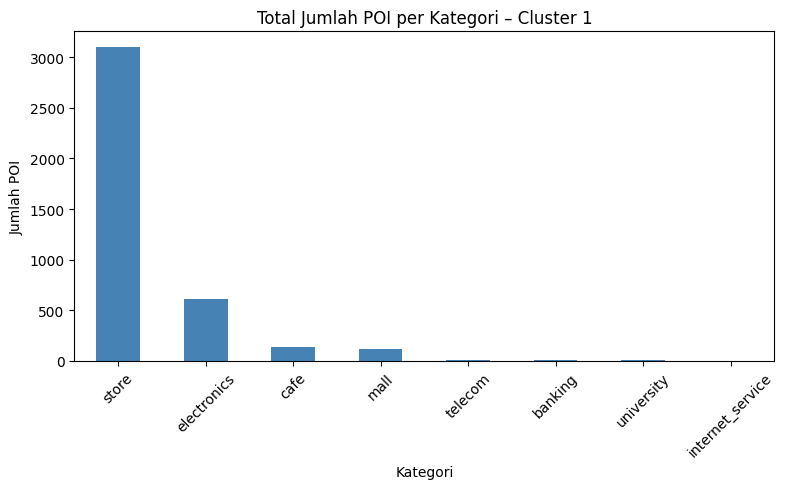

In [84]:
cluster1_totals = merged[merged['cluster_kmodes'] == 0][category_cols].sum()

# === plot ===
plt.figure(figsize=(8,5))
cluster1_totals.sort_values(ascending=False).plot(kind='bar', color='steelblue')
plt.title('Total Jumlah POI per Kategori – Cluster 1')
plt.ylabel('Jumlah POI')
plt.xlabel('Kategori')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [89]:
print("Cluster 1")
cluster1_totals

Cluster 1


banking               10.0
cafe                 142.0
electronics          616.0
internet_service       2.0
mall                 117.0
store               3101.0
telecom               10.0
university             5.0
dtype: float64

- Dominasi POI berupa toko - toko ritel dan toko elektronik
- lifestyle cafe/mall tidak terlalu dominan
- yang rendah banking, university, telecom
- Kabupaten/kota diisi oleh bagian "menengah" bisa dilihat dari Kota-kota yang cukup besar namun kurang familiar jika membahas terkait "digital"-nya

============================================================================
Analisa: Electronics + Store cities
- Kota menengah -> Besar
- Banyak kota besar-menengah / pusat dagang regional (sering ibukota kabupaten/kota) dimana daya beli itu tumbuh cuma belum sekenceng dari daerah "mega-hub"
- Elektronik tertinggi ada indikasi persebaran pengguna smartphone/device lain banyak di cluster ini
- Walaupun terlihat rendah di bagian "internet" bisa jadi karena kekurangan data dari OSM namun bisa dibackup dari data toko elektronik yang tinggi.

Penetrasi: Dari toko elektronik?? promo disana mungkin?

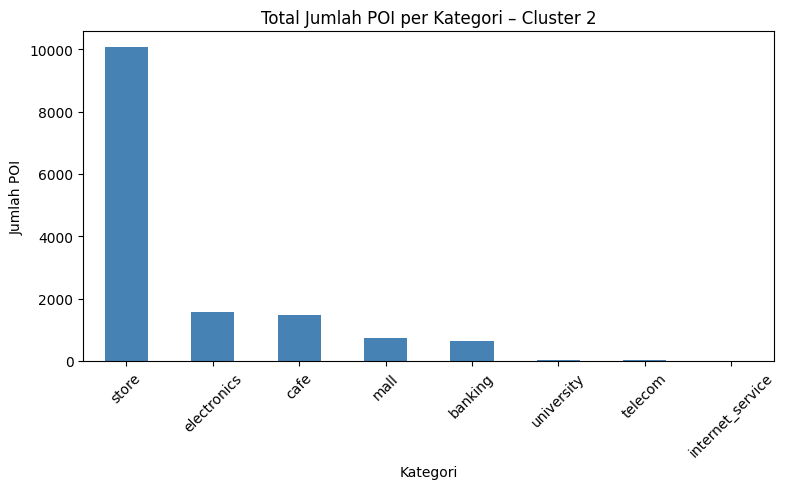

In [85]:
cluster2_totals = merged[merged['cluster_kmodes'] == 1][category_cols].sum()

# === plot ===
plt.figure(figsize=(8,5))
cluster2_totals.sort_values(ascending=False).plot(kind='bar', color='steelblue')
plt.title('Total Jumlah POI per Kategori – Cluster 2')
plt.ylabel('Jumlah POI')
plt.xlabel('Kategori')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [90]:
print("Cluster 2")
cluster2_totals

Cluster 2


banking               654.0
cafe                 1483.0
electronics          1575.0
internet_service        9.0
mall                  746.0
store               10075.0
telecom                22.0
university             29.0
dtype: float64

- Dominan store, electronics, cafe, banking, mall menonjol sekaligus.
- Disini wilayah dengan digital yang cukup "advance"
- Masuk ke kategori Kabupaten/kota yang sudah melek 
digital dibuktikan dengan daerah daerah seperi Jabodetabek dan wilayah wisata seperti Kota Denpasar.
============================================================================
Analisa: Mega-hub
- Dominan daerah Jawa/luar Jawa namun yang sudah "menonjol" (Bali, Lombok, Manado, dll)
- Toko paling banyak jelas kalo diliat dari "PwC Indonesia Economic Update" ->  Java Island is still the largest contributor to Indonesia economy at 57.05% with an average growth of 4.96% (YoY)
- Keseluruhan untuk pasar (store,cafe,mall,elektronik) semua tinggi jadi berhubungan untuk industrinya (aglomerasi?) -> POI Padat karena saling terdorong
- Toko ritel sudah masuk ke yang modern (dilihat dari jumlahnya banyak toko kecil + toko besar)

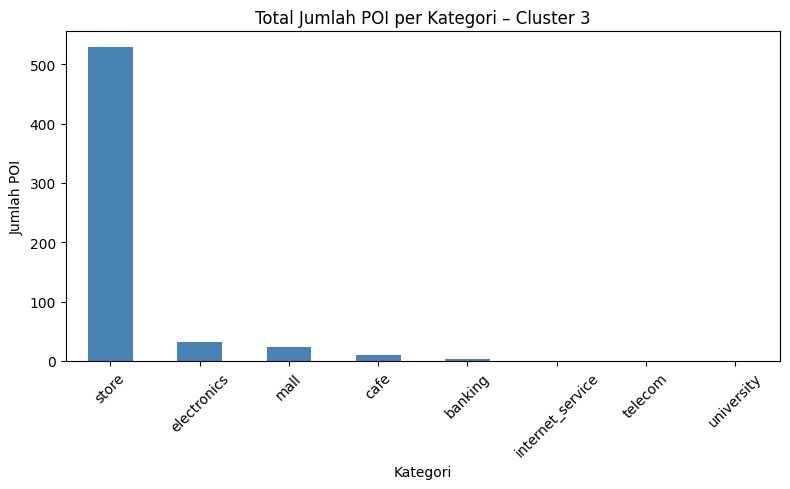

In [86]:
cluster3_totals = merged[merged['cluster_kmodes'] == 2][category_cols].sum()

# === plot ===
plt.figure(figsize=(8,5))
cluster3_totals.sort_values(ascending=False).plot(kind='bar', color='steelblue')
plt.title('Total Jumlah POI per Kategori – Cluster 3')
plt.ylabel('Jumlah POI')
plt.xlabel('Kategori')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [91]:
print("Cluster 3")
cluster3_totals

Cluster 3


banking               3.0
cafe                 10.0
electronics          31.0
internet_service      0.0
mall                 24.0
store               529.0
telecom               0.0
university            0.0
dtype: float64

- Dominan store.
- Untuk bagian telecom/ internet service nya tidak ada 
- Masuk daerah-daerah seperti kepuluan seperti halmahera, raja ampat (bisa jadi belum terdaftar juga yang terbaru terkait poi internet nya)
- Digital readiness nya kurang
============================================================================
Analisa: Digitalnya kemana??
- masuk daerah - daerah kepulauan dengan urbanisasi terbatas sehingga daya beli rendah -> selain toko ritel jadi dikit.
- Infrastruktur digital (banking, internet service, telecom) belum terbangun kuat.

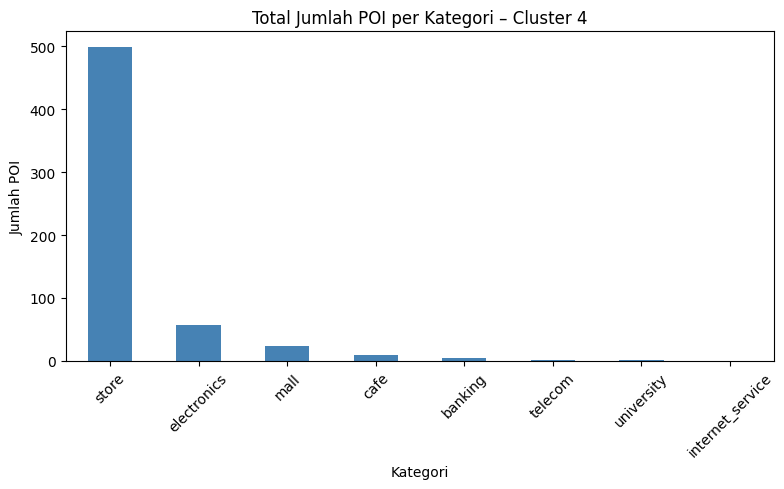

In [87]:
cluster4_totals = merged[merged['cluster_kmodes'] == 3][category_cols].sum()

# === plot ===
plt.figure(figsize=(8,5))
cluster4_totals.sort_values(ascending=False).plot(kind='bar', color='steelblue')
plt.title('Total Jumlah POI per Kategori – Cluster 4')
plt.ylabel('Jumlah POI')
plt.xlabel('Kategori')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [92]:
print("Cluster 4")
cluster4_totals

Cluster 4


banking               5.0
cafe                 10.0
electronics          57.0
internet_service      0.0
mall                 23.0
store               499.0
telecom               1.0
university            1.0
dtype: float64

- Dominan store
- electronic, mall ada namun dikit
- sudah masuk ke ritel-ritel modern
- lifestyle hampir masuk cluster 3
- store oriented -> jika dibandingkan dengan poi lainnya
- sepertinya masuk ke wilayah rural/kabupaten yang masih pedesaan?
- Akses digital (banking, university, telecom) nyaris tidak ada.

Cluster 2 = Mega urban digital hubs (semua kategori kuat → lifestyle, banking, store, mall).

Cluster 1 = Electronics + store cities (daya beli tumbuh, fokus perangkat & ritel).

Cluster 3 & 4 = Store-oriented / low-readiness (ritel dasar ada, infrastruktur lain minim).

In [93]:
data = pd.read_csv('poi_osm/fix/osm_poi_kode.csv')

In [94]:
data

,Unnamed: 0.1,Unnamed: 0,id,kabupaten_kota,Kode_Kabupaten,name,category,latitude,longitude,addr:city,source
0,0,0,node/411668893,Jakarta Barat,31.73,Hero,supermarket,-6.165670,106.759241,NaN,NaN
1,1,1,node/412686079,Jakarta Barat,31.73,Super Indo,supermarket,-6.165414,106.782067,NaN,NaN
2,2,2,node/1354554837,Jakarta Barat,31.73,NaN,atm,-6.189133,106.796257,NaN,NaN
3,3,3,node/1354554844,Jakarta Barat,31.73,CFC,restaurant,-6.189235,106.796378,NaN,NaN
4,4,4,node/1541706845,Jakarta Barat,31.73,Super Indo,supermarket,-6.216578,106.765227,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
56161,56161,56161,way/1159592008,Tulangbawang,18.05,NaN,chemist,NaN,NaN,NaN,NaN
56162,56162,56162,way/1160380538,Tulangbawang,18.05,NaN,kiosk,NaN,NaN,NaN,NaN
56163,56163,56163,way/1186182191,Tulangbawang,18.05,NaN,yes,NaN,NaN,NaN,NaN
56164,56164,56164,way/1186354872,Tulangbawang,18.05,Alfamart,convenience,NaN,NaN,NaN,NaN


In [106]:
data = data[data['kabupaten_kota'] =="Kota Bandung"]


In [108]:
data.to_csv('test_path.csv')

In [103]:
data.head(30).to_excel('output.xlsx')

In [114]:
data.dropna().to_csv('test_path.csv')